In [1]:
import time

In [2]:
tic = time.time()

In [3]:
import configparser
import warnings
import os.path as op
import numpy as np
import nibabel as nib
import dipy.data as dpd
import dipy.tracking.utils as dtu
import dipy.tracking.streamline as dts
from dipy.io.streamline import save_tractogram, load_tractogram
from dipy.stats.analysis import afq_profile, gaussian_weights
from dipy.io.stateful_tractogram import StatefulTractogram
from dipy.io.stateful_tractogram import Space
import dipy.core.gradients as dpg
from dipy.reconst import dti
from dipy.reconst import csdeconv as csd

import AFQ.data as afd
import AFQ.tractography as aft
import AFQ.registration as reg
import AFQ.segmentation as seg

import s3fs

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/stats/__init__.py:7: UserWarning: The `dipy.stats` module is still under heavy development and functionality, as well as the API is likely to change in future versions of the software
  warnings.warn(w_string)


In [4]:
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
ak = CP.get('hcp', 'AWS_ACCESS_KEY_ID')
sk = CP.get('hcp', 'AWS_SECRET_ACCESS_KEY')

In [5]:
fs = s3fs.S3FileSystem(key=ak, secret=sk)

In [6]:
subject = 100307

In [7]:
with fs.open(f'hcp-openaccess/HCP_1200/{subject}/T1w/Diffusion/bvals') as ff:
    bvals = np.loadtxt(ff)

In [8]:
with fs.open(f'hcp-openaccess/HCP_1200/{subject}/T1w/Diffusion/bvecs') as ff:
    bvecs = np.loadtxt(ff) 

In [9]:
gtab = dpg.gradient_table(bvals, bvecs, b0_threshold=50)

In [10]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

In [11]:
n_workers = 100

In [12]:
cluster = KubeCluster(n_workers=n_workers)
cluster

In [13]:
client = Client(cluster)
client

Client Scheduler: tcp://192.168.24.6:39019 Dashboard: /user/arokem/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [14]:
dwi_fname = f'hcp-openaccess/HCP_1200/{subject}/T1w/Diffusion/data.nii.gz'
dwi_img = afd.s3fs_nifti_read(dwi_fname, fs=fs)

In [15]:
mock_data = np.zeros(dwi_img.shape[:3])

In [16]:
wm_labels=[250, 251, 252, 253, 254, 255, 41, 2, 16, 77]
seg_fname = f'hcp-openaccess/HCP_1200/{subject}/T1w/aparc+aseg.nii.gz'
seg_img = afd.s3fs_nifti_read(seg_fname, fs=fs)
seg_data = seg_img.get_fdata()

wm_mask = np.sum(np.concatenate([(seg_data == l)[..., None]
                                for l in wm_labels], -1), -1)

wm_mask = np.round(reg.resample(wm_mask, 
                                mock_data,
                                seg_img.affine,
                                dwi_img.affine)).astype(int)

In [17]:
wm_idx = np.where(wm_mask)

In [18]:
dwi_data = dwi_img.get_data()

In [19]:
wm_data = dwi_data[wm_idx]

In [20]:
wm_data.shape

(219506, 288)

In [21]:
from dask import delayed

In [22]:
import dask.array as da

In [23]:
da_wm_data = da.from_array(
    wm_data, 
    chunks=(wm_data.shape[0]//n_workers, -1))

In [24]:
da_wm_data

,Array,Chunk
Bytes,252.87 MB,2.53 MB
Shape,"(219506, 288)","(2195, 288)"
Count,102 Tasks,101 Chunks
Type,float32,numpy.ndarray


In [25]:
def compute_fa(data):
    dtm = dti.TensorModel(gtab)
    dtf = dtm.fit(data)
    return dtf.fa

In [26]:
fa = da_wm_data.map_blocks(compute_fa, drop_axis=1)

In [27]:
fa_vol = np.zeros(wm_mask.shape)

In [28]:
fa_vol[np.where(wm_mask)] = fa.compute()

In [29]:
import matplotlib.pyplot as plt

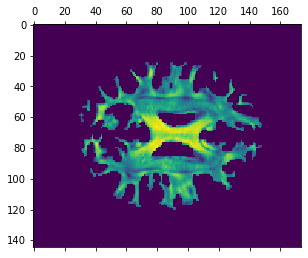

In [30]:
plt.matshow(fa_vol[:, :, fa_vol.shape[2]//2])

In [31]:
response = csd.auto_response(gtab, dwi_data)[0]

In [32]:
response

(array([0.00129317, 0.000234  , 0.000234  ]), 3106.3787)

In [33]:
def compute_csd(data):
    cm = csd.ConstrainedSphericalDeconvModel(gtab, response)
    cf = cm.fit(data)
    return cf.shm_coeff

In [34]:
csd_vol = np.zeros(wm_mask.shape + (45,))

In [35]:
csd_vol.shape

(145, 174, 145, 45)

In [36]:
csd_vol[np.where(wm_mask)] =\
    da_wm_data.map_blocks(compute_csd, dtype=float).compute()

In [37]:
dwi_img_affine = dwi_img.affine

In [38]:
wm_mask_shape = wm_mask.shape

In [39]:
csd_img = nib.Nifti1Image(csd_vol, dwi_img_affine)

In [40]:
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
ak = CP.get('default', 'AWS_ACCESS_KEY_ID')
sk = CP.get('default', 'AWS_SECRET_ACCESS_KEY')

In [41]:
my_fs = s3fs.S3FileSystem(key=ak, secret=sk)

In [42]:
afd.s3fs_nifti_write(csd_img, 
                     f'hcp.pangeo.experiments/{subject}/csd.nii.gz', 
                     fs=my_fs)

In [43]:
fa_img = nib.Nifti1Image(fa_vol, dwi_img_affine)

In [44]:
afd.s3fs_nifti_write(fa_img, 
                     f'hcp.pangeo.experiments/{subject}/fa.nii.gz',
                     fs=my_fs)

In [45]:
def track_csd(params):
    seed_idxes, ii = params
    seed_mask = np.zeros(wm_mask_shape)
    seed_mask[seed_idxes[0],
              seed_idxes[1],
              seed_idxes[2]] = 1
    csd_img = afd.s3fs_nifti_read(
        f'hcp.pangeo.experiments/{subject}/csd.nii.gz', 
        fs=my_fs)
    fa_img = afd.s3fs_nifti_read(
        f'hcp.pangeo.experiments/{subject}/fa.nii.gz', 
        fs=my_fs)
    fa_vol = fa_img.get_fdata()
    sl = aft.track(csd_img, 
                   seed_mask=seed_mask, 
                   stop_mask=fa_vol, 
                   stop_threshold=0.1,
                   n_seeds=2)
    sft = StatefulTractogram(sl, fa_img, Space.RASMM)
    save_tractogram(sft, './csd_streamlines.trk',
                    bbox_valid_check=False)
    my_fs.upload('csd_streamlines.trk', 
                 f'hcp.pangeo.experiments/{subject}/sl-{ii:03d}.trk')
    return len(sl)

In [46]:
arr_wm_idx = np.array(wm_idx)

In [47]:
n_chunks = n_workers

In [48]:
chunk_size = arr_wm_idx.shape[-1] // n_chunks

In [49]:
chunk_size

2195

In [50]:
chunks = [arr_wm_idx[:, i*chunk_size:(i+1)*chunk_size] for i in range(n_chunks)]

In [51]:
len(chunks)

100

In [52]:
chunks[-1].shape

(3, 2195)

In [53]:
# sl_test = track_csd(chunks[-1])

In [54]:
n_passes = 3

In [55]:
sl_futures = []
for chunk_idx in range(n_passes):
    these_chunks = chunks[chunk_idx * len(chunks) // n_passes:
                          (chunk_idx + 1) * len(chunks) // n_passes]
    iis = np.arange(chunk_idx * len(chunks) // n_passes,  
                    (chunk_idx + 1) * len(chunks) // n_passes)
    for ii, chunk in zip(iis, these_chunks):
        sl_futures.append(client.submit(track_csd, (chunk, ii)))            

In [56]:
from tqdm import tqdm_notebook as tqdm

In [57]:
all_done = False 
pbar = tqdm(total=len(sl_futures))
n_done = 0
while not all_done:
    n_done_now = sum([r.done() for r in sl_futures])
    if n_done_now > n_done:
        pbar.update(n_done_now - n_done)
        n_done = n_done_now

    all_done = n_done == len(sl_futures)

In [58]:
toc = time.time()

In [59]:
(toc - tic) / 60

10.706760629018147

In [60]:
n_sl = 0
for fut in sl_futures:
    try:
        n_sl = n_sl + fut.result()
    except:
        pass
    

In [61]:
print(n_sl)

2646815
